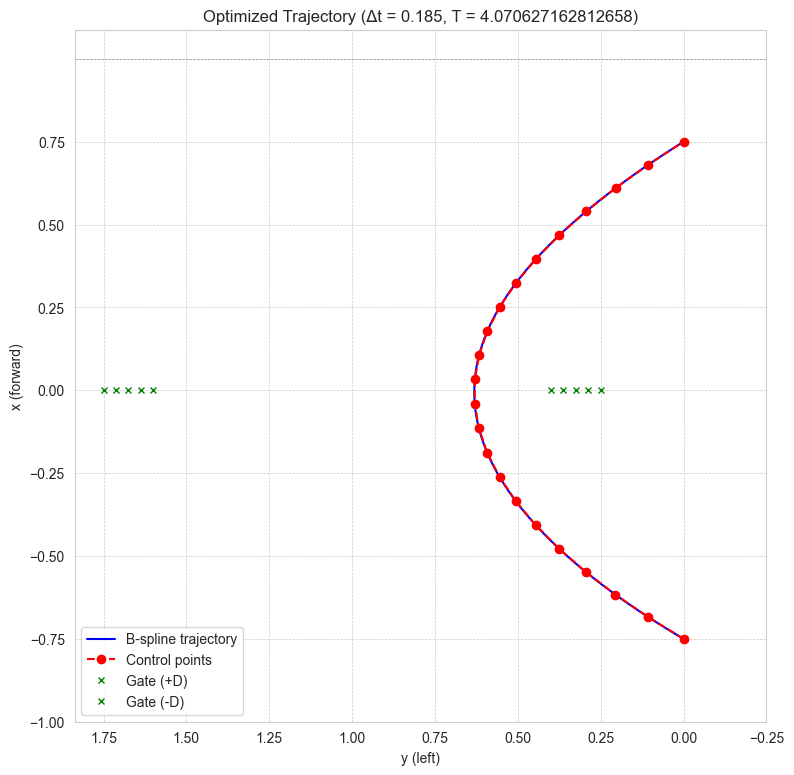

In [156]:
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

# Parameters
N = 21  # control segments
D = 0.2  # distance from gate center
k = 0.6

#30, 1, 500

lambda_jerk = 30.0
lambda_gate = 1.0  # penalty for violating gate constraint
lambda_T = 1500.0
start = np.array([-0.75, 0.0])
end = np.array([0.75, 0.0])

# Optimization variables: x[1:N], y[1:N], delta_t
x_var_init = np.linspace(start[0], end[0], N+1)[1:-1]  # exclude start and end
y_var_init = 0.5*np.ones(N-1)
delta_t_init = 0.1
z_init = np.hstack((x_var_init, y_var_init, delta_t_init))

# Objective function
def objective(z):
    x_mid = z[:N - 1]
    y_mid = z[N - 1:2 * (N - 1)]
    delta_t = z[-1]

    # Reconstruct full x and y with fixed start/end
    x = np.hstack(([start[0]], x_mid, [end[0]]))
    y = np.hstack(([start[1]], y_mid, [end[1]]))

    acc_x = (x[2:] - 2 * x[1:-1] + x[:-2]) / delta_t ** 2
    acc_y = (y[2:] - 2 * y[1:-1] + y[:-2]) / delta_t ** 2

    acc = np.sum(acc_x**2 + acc_y**2)

    # 3rd-order jerk
    jerk_x = (x[3:] - 3 * x[2:-1] + 3 * x[1:-2] - x[:-3]) / delta_t**3
    jerk_y = (y[3:] - 3 * y[2:-1] + 3 * y[1:-2] - y[:-3]) / delta_t**3
    jerk = np.sum(jerk_x**2 + jerk_y**2)

    # Gate constraint penalty
    gate_pe_x, gate_pe_y = x , y #[N//2-4:N//2+4][N//2-5:N//2+5]
    gate_penalty = np.sum((gate_pe_x**2 + (gate_pe_y - 1.0 + k)**2 - D**2)**2) + np.sum((gate_pe_x**2 + (gate_pe_y - 1.0 - k)**2 - (D)**2)**2)

    return lambda_T * delta_t + lambda_jerk * (jerk+acc) + lambda_gate * gate_penalty

# Bounds: x_mid, y_mid ∈ [-5, 5]; delta_t ∈ [0.01, 1.0]
bounds = [(-5, 5)] * (2 * (N - 1)) + [(0.01, 1.0)]

# Run optimization
res = minimize(objective, z_init, bounds=bounds, method='L-BFGS-B')

x_mid = res.x[:N - 1]
y_mid = res.x[N - 1:2 * (N - 1)]
delta_t_opt = res.x[-1]

# Reconstruct full trajectory
x_opt = np.hstack(([start[0]], x_mid, [end[0]]))
y_opt = np.hstack(([start[1]], y_mid, [end[1]]))

# Optional: spline interpolation for smooth trajectory
t = np.linspace(0, 1, len(x_opt))
t_smooth = np.linspace(0, 1, 200)
spline_x = make_interp_spline(t, x_opt)(t_smooth)
spline_y = make_interp_spline(t, y_opt)(t_smooth)

# Optional: plot (for visualization if needed)
plt.figure(figsize=(8, 8))
plt.plot(spline_y, spline_x, label="B-spline trajectory", color='blue')
plt.plot(y_opt, x_opt, 'ro--', label="Control points")
plt.plot(np.linspace(1+k, 1 + k + 0.15, 5), np.zeros(5), 'gx', markersize=4, label='Gate (+D)')
plt.plot(np.linspace(1-k-0.15, 1 -k, 5), np.zeros(5), 'gx', markersize=4, label='Gate (-D)')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)
plt.title(f"Optimized Trajectory (Δt = {delta_t_opt:.3f}, T = {delta_t_opt * (N+1)})")
plt.xlabel("y (left)")
plt.ylabel("x (forward)")
plt.legend()

plt.xticks(np.arange(-0.25, 2, 0.25))
plt.yticks(np.arange(-1, 1, 0.25))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')  # 거리 비율 고정
plt.gca().invert_xaxis()

plt.tight_layout()
plt.show()

In [125]:
spline_x

array([-7.50000000e-01, -7.43087781e-01, -7.36160193e-01, -7.29217259e-01,
       -7.22259004e-01, -7.15285454e-01, -7.08296631e-01, -7.01292561e-01,
       -6.94273268e-01, -6.87238777e-01, -6.80189112e-01, -6.73124297e-01,
       -6.66044357e-01, -6.58949317e-01, -6.51839200e-01, -6.44714032e-01,
       -6.37573836e-01, -6.30418638e-01, -6.23248462e-01, -6.16063331e-01,
       -6.08863279e-01, -6.01648366e-01, -5.94418659e-01, -5.87174223e-01,
       -5.79915125e-01, -5.72641431e-01, -5.65353208e-01, -5.58050522e-01,
       -5.50733439e-01, -5.43402031e-01, -5.36056454e-01, -5.28696936e-01,
       -5.21323706e-01, -5.13936994e-01, -5.06537029e-01, -4.99124040e-01,
       -4.91698258e-01, -4.84259911e-01, -4.76809229e-01, -4.69346430e-01,
       -4.61871696e-01, -4.54385202e-01, -4.46887125e-01, -4.39377639e-01,
       -4.31856920e-01, -4.24325145e-01, -4.16782488e-01, -4.09229124e-01,
       -4.01665235e-01, -3.94091053e-01, -3.86506853e-01, -3.78912909e-01,
       -3.71309498e-01, -

-3.4696699141100895 3.4696699141100895
-4.5303300858899105 -3.4696699141100895
-4.5303300858899105 -4.5303300858899105
-3.4696699141100895 -4.5303300858899105
3.4696699141100895 -3.4696699141100895
4.5303300858899105 3.4696699141100895
4.5303300858899105 4.5303300858899105
3.4696699141100895 4.5303300858899105


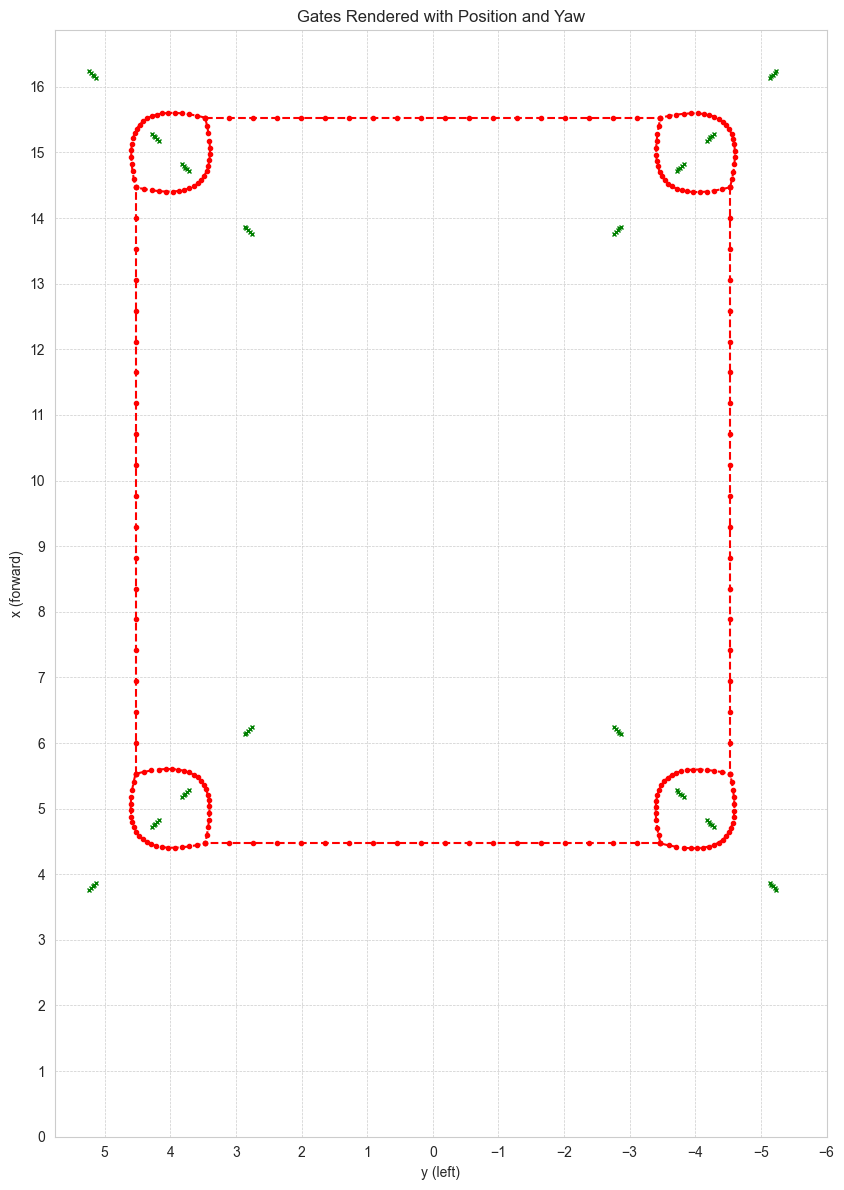

In [165]:
import matplotlib.pyplot as plt
import numpy as np

# Define gate geometry: gate bar center at y = 1 ± k, height irrelevant here
k = 0.6  # half-gap offset from center
bar_width = 0.15  # width of each gate bar
bar_length = 0.15  # spread along y-axis before rotation
num_points = 5  # number of samples per gate bar

# Gate definitions: (name, x, y, z, yaw in degrees)
gate_defs = [
    ("gate_pair_00",  5.0, -4.0, 0.0,  -45),
    ("gate_pair_01", 15.0, -4.0, 0.0,   45),
    ("gate_pair_02", 15.0,  4.0, 0.0,  135),
    ("gate_pair_03",  5.0,  4.0, 0.0, -135),
]

def rotate_and_translate(x_local, y_local, yaw_deg, tx, ty):
    yaw_rad = np.radians(yaw_deg)
    cos_yaw = np.cos(yaw_rad)
    sin_yaw = np.sin(yaw_rad)
    x_global = cos_yaw * x_local - sin_yaw * y_local + tx
    y_global = sin_yaw * x_local + cos_yaw * y_local + ty
    return x_global, y_global

# Plotting
plt.figure(figsize=(12, 12))

end_points=[]

for name, x, y, z, yaw in gate_defs:
    for case in [[1+k, 1+k+bar_length], [1 - k - bar_length, 1 - k], [-1 +k, -1 + k + bar_length],[-1 - k - bar_length,-1 - k],]:

        y_bar_plus = np.linspace(case[0], case[1], num_points)
        x_bar_plus = np.zeros_like(y_bar_plus)
        x_global_plus, y_global_plus = rotate_and_translate(x_bar_plus, y_bar_plus, yaw, x, y)
        plt.plot(y_global_plus, x_global_plus, 'gx', markersize=3)

    x_opt_t, y_opt_t = rotate_and_translate(x_opt, y_opt, yaw, x, y)
    plt.plot(y_opt_t, x_opt_t, 'ro--', label="Control points", markersize=3)

    x_opt_t, y_opt_t = rotate_and_translate(x_opt, -y_opt, yaw, x, y)
    plt.plot(y_opt_t, x_opt_t, 'ro--', label="Control points", markersize=3)

    end_points.append([y_opt_t[0], x_opt_t[0]])
    end_points.append([y_opt_t[-1], x_opt_t[-1]])

for i in range(len(end_points)):
    s = end_points[i]
    e = end_points[(7+i)%8]

    print(s[0], e[0])
    if s[0] == e[0]:
        y_line = s[0]*np.ones(20)
        x_line = np.linspace(s[1], e[1], 20)
        plt.plot(y_line, x_line, 'ro--', label="inter point", markersize=3)

    if s[1] == e[1]:
        x_line = s[1]*np.ones(20)
        y_line = np.linspace(s[0], e[0], 20)
        plt.plot(y_line, x_line, 'ro--', label="inter point", markersize=3)



# Formatting
plt.xticks(np.arange(-6, 6, 1))
plt.yticks(np.arange(0, 17, 1))
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_xaxis()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel("y (left)")
plt.ylabel("x (forward)")
plt.title("Gates Rendered with Position and Yaw")
plt.tight_layout()
plt.show()
